# Machine Learning Essentials SS25 - Exercise Sheet 7

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix, coo_matrix
from scipy.sparse.linalg import lsqr

DATA_DIR = "hs_tomography"  # Change this to your data directory

## Task 1


In [8]:
size = 77
sensor_size = 109


alphas = np.load(f'./{DATA_DIR}/alphas_{size}.npy')
X_example = np.load(f'./{DATA_DIR}/X_example.npy')


alphas_195 = np.load(f'./{DATA_DIR}/alphas_{195}.npy')

In [9]:
def construct_X(M, alphas, Np=None):
    # TODO: implement vectorised sparse projection matrix X, according to the instructions on the sheet. Remember to vectorize everything (no for-loops over pixels) and use the mentioned matrix formats (COOrdinate/Compressed Sparse Column). The large case (`M=195`) should build in approx. < 10s on a laptop.
    if Np==None:
        Np = int(np.ceil(np.sqrt(2)*M))
    
    D = M*M
    

    # C matrix with pixel centers of shape (2, D)

    a, b = np.mgrid[-(M-1)/2:(M-1)/2+1, (M-1)/2:-(M-1)/2-1:-1]
    C = np.vstack([a.ravel(order='F'), b.ravel(order='F')])

    # unit vectors
    alphas = np.deg2rad(alphas)  
    unit_vectors = np.array([np.cos(alphas), np.sin(alphas)])
    s0 = (Np-1)/2

    row_indices = []
    col_indices = []
    weights = []

    for i, alpha in enumerate(alphas):
        
        n = unit_vectors[:, i].reshape(2, 1)

        P = (n.T @ C).flatten() + s0
        
        idx_left = np.floor(P).astype(int)
        idx_right = idx_left + 1

        frac = P - idx_left

        w0 = (1 - frac)
        w1 = frac

        mask0 = (idx_left >= 0) & (idx_left < Np)
        mask1 = (idx_right >= 0) & (idx_right < Np)

        row0 = idx_left[mask0] + i * Np
        row1 = idx_right[mask1] + i * Np

        col0 = np.where(mask0)[0]
        col1 = np.where(mask1)[0]

        row_indices.append(row0)
        row_indices.append(row1)
        col_indices.append(col0)
        col_indices.append(col1)
        weights.append(w0[mask0])
        weights.append(w1[mask1])

    if weights:
        row_indices = np.concatenate(row_indices)
        col_indices = np.concatenate(col_indices)
        weights = np.concatenate(weights)

    else:
        row_indices = np.array([], dtype=int)
        col_indices = np.array([], dtype=int)
        weights = np.array([], dtype=np.float32)

    return coo_matrix((weights, (row_indices, col_indices)), shape=(len(alphas) * Np, D), dtype=np.float32)


### Quick sanity check 


In [28]:
# TODO: Check if your image matches `X_example.npy` (Figure 2) up to mirror / transpose.
X = construct_X(10, np.array([-33, 1, 42])).toarray()
print(f'The images match numerically: {np.allclose(X, X_example, atol=1e-5)}')

The images match numerically: True


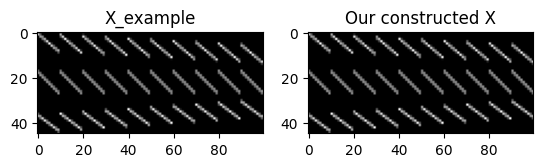

The Xs match visually


In [38]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(X_example, cmap = 'gray')
axs[0].set_title('X_example')
axs[1].imshow(X, cmap = 'gray')
axs[1].set_title('Our constructed X')
plt.show()
print('The Xs match visually')

In [11]:
X_77 = construct_X(size, alphas, sensor_size)
X_195 = construct_X(195, alphas_195, 275)

## Task 2 – Reconstruct the tomogram

In [52]:
# TODO: Reconstruct the tomogram and plot it as a 2D image. Use scipy.sparse.linalg.lqsr() to make use of the sparsity of your matrix, see the instructions on the sheet.
M = 195 # Choose between 77 & 195

X = X_77 if M == 77 else X_195

# Load response vector
y = np.load(f'./{DATA_DIR}/y_{M}.npy')

# Solve using efficient least squares with sparse matrix
beta = lsqr(X, y)[0]


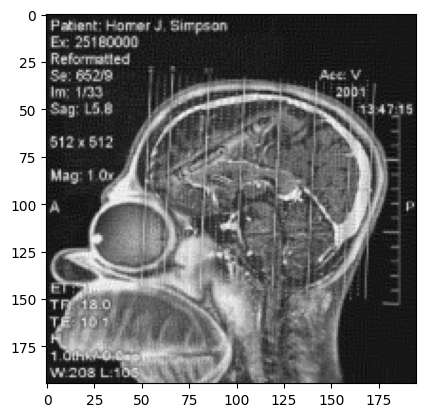

In [53]:
# Unflatten to 2d image and display
mu = beta.reshape(M,M)

plt.imshow(mu, cmap = 'gray')
plt.show()

### Diagnosis
TODO: The issue likely stems from the crayon stuck in Mr Simpson's brain. We would recommend removing it.


## Task 3 

In [72]:
1.25*125

156.25

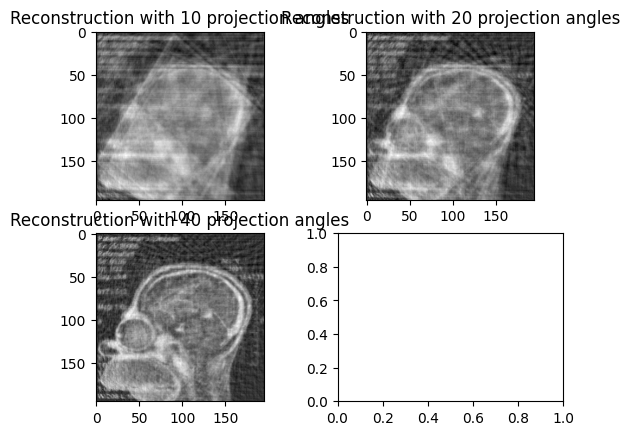

In [ ]:
def reconstruct_with_subset():
    # TODO: Reconstruct X using only a subset of projection angles.
    M = 195 # Image resolution along one axis

    # Set reduced numbers of angles and set up plotting
    N_subs = [20,40,80,120,160]
    fig, axs = plt.subplots(int(np.ceil(len(N_subs)/2)),2)
    axs = axs.flatten()

    # Other relevant arrays and values
    alphas = np.load(f'./{DATA_DIR}/alphas_{M}.npy')
    y = np.load(f'./{DATA_DIR}/y_{M}.npy')

    No = len(alphas) # = 179
    Np = 275

    y_sino = y.reshape(No, Np)

    for i, N_sub in enumerate(N_subs):
        # Obtain mask extracting N_sub regularly spaced indices to extract
        mask = np.linspace(0, No-1, N_sub, dtype = int) 

        # Extract subset of projection angles, and reduce sinogram accordingly
        alphas_sub = alphas[mask]
        y_sub = y_sino[mask].flatten()

        # Create reconstructed X and solve problem.
        X_sub = construct_X(M, alphas_sub, Np)
        beta = lsqr(X_sub, y_sub)[0]
        mu = beta.reshape(M,M)

        # Plot
        axs[i].imshow(mu, cmap = 'gray')
        axs[i].set_title(f'Reconstruction with {N_sub} projection angles')

    plt.show()
        

# TODO: Reduce the number of projection angles in a sensible way and visualize how the reconstruction is affected by the number of angles used.
reconstruct_with_subset()

In [89]:
y.shape

(49225,)

In [91]:
275*179

49225

In [98]:
X_sub.shape

(2750, 38025)

In [100]:
y_sino.shape

(179, 275)

In [99]:
y_sub.shape

(1790,)

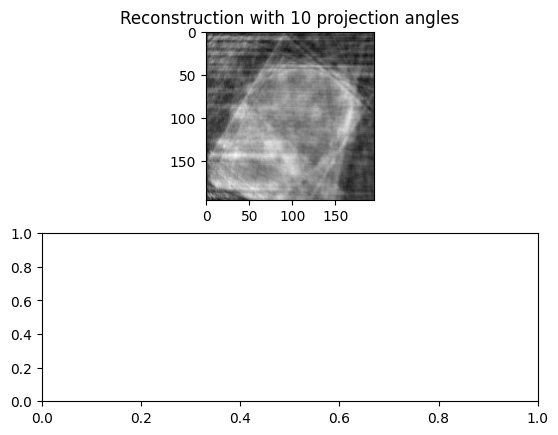

In [86]:
X_sub.shape

(1090, 38025)

TODO: state the smallest number of projections that still resolves the pathology clearly enough to give a diagnosis and propose a treatment.
